# Data Preprocessing/Feature Engineering

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [4]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix,classification_report
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_csv("/content/understat.com.csv")

In [6]:
df.rename(columns = {"Unnamed: 0": "league", "Unnamed: 1":"year"}, inplace = True)

In [7]:
temp_df=df.copy()

In [8]:
temp_df["first_position"] = np.where(temp_df["position"]==1, 1, 0)

In [9]:
categ_col = temp_df.select_dtypes(include=['object', 'category']).columns
categ_col

Index(['league', 'team'], dtype='object')

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
for i in categ_col:
    temp_df[i] = le.fit_transform(temp_df[i])

In [11]:
temp_df.head()

,league,year,position,team,matches,wins,draws,loses,scored,missed,...,xGA_diff,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,first_position
0,2,2014,1,14,38,30,4,4,110,21,...,7.444293,24.727907,73.049305,5.683535,16.367593,489,114,94.0813,0.0813,1
1,2,2014,2,123,38,30,2,6,118,38,...,4.607198,38.890805,47.213090,10.209085,12.929510,351,153,81.7489,-10.2511,0
2,2,2014,3,12,38,23,9,6,67,29,...,0.069107,26.839271,25.748737,8.982028,9.237091,197,123,73.1353,-4.8647,0
3,2,2014,4,157,38,22,11,5,70,32,...,7.392572,33.446477,16.257501,8.709827,7.870225,203,172,63.7068,-13.2932,0
4,2,2014,5,138,38,23,7,8,71,45,...,2.862742,41.916529,20.178070,8.276148,9.477805,305,168,67.3867,-8.6133,0


In [12]:
temp_df['first_position'].value_counts()

0    648
1     36
Name: first_position, dtype: int64

There is an imbalance in the target class, so we'll have to upsample the minority class to avoid the model predicting only one class.

# Upsampling

In [13]:
# Separate majority and minority classes
majority = temp_df[temp_df.first_position==0]
minority = temp_df[temp_df.first_position==1]
 
# Upsample minority class
minority_upsampled = resample(minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=648,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
upsampled = pd.concat([majority, minority_upsampled])
 
# Display new class counts
upsampled.first_position.value_counts()

0    648
1    648
Name: first_position, dtype: int64

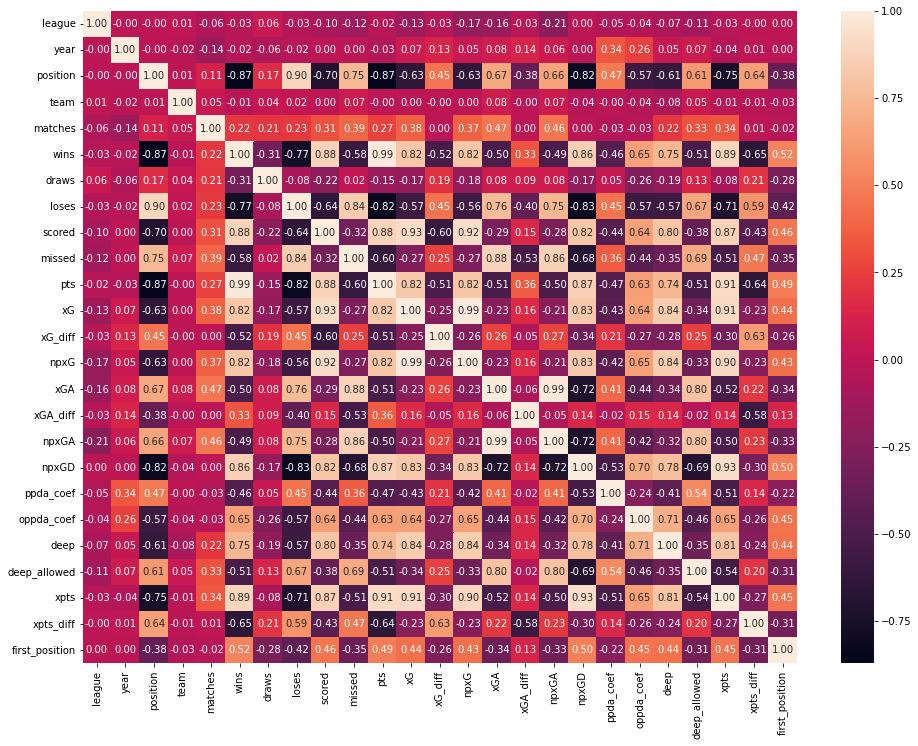

In [23]:
corr=temp_df.corr()
fig=plt.subplots(figsize=(16,12))
sns.heatmap(corr, annot= True, fmt=".2f")

In [16]:
y = upsampled.first_position
x = upsampled.drop(columns=['wins','draws','loses','scored', 'missed', 'pts', 'first_position', 'position', 'xG_diff', 'xGA_diff', 'xpts_diff'], axis = 1)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test),columns=x_test.columns)

# Modeling

### Logistic Regression

In [24]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
clf_pred = clf.predict(x_test)
clf_accuracy = accuracy_score(y_test, clf_pred)
clf_matrix = confusion_matrix(y_test, clf_pred)
clf_f1 = f1_score(clf_pred, y_test, average = 'macro')

In [25]:
print('Accuracy on Logistic Regression is: {}'.format(clf_accuracy))
print('F1_score on Logistic Regression is: {}'.format(clf_f1))
print("The classification report ")
print(classification_report(y_test,clf_pred))

Accuracy on Logistic Regression is: 0.926923076923077
F1_score on Logistic Regression is: 0.9269219958875131
The classification report 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       132
           1       0.92      0.94      0.93       128

    accuracy                           0.93       260
   macro avg       0.93      0.93      0.93       260
weighted avg       0.93      0.93      0.93       260



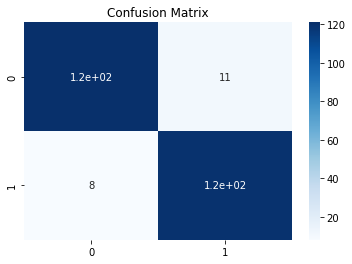

In [26]:
Confusion_mat=confusion_matrix(y_test,clf_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")

### Decision Tree Classifier

In [27]:
dtc = DecisionTreeClassifier(random_state=1).fit(x_train, y_train)
dtc_pred = dtc.predict(x_test)
dtc_accuracy = accuracy_score(y_test, dtc_pred)
dtc_matrix = confusion_matrix(y_test, dtc_pred)
dtc_f1 = f1_score(dtc_pred, y_test, average = 'macro')

In [28]:
print('Accuracy on Decision Tree Classifier is: {}'.format(dtc_accuracy))
print('F1_score on Decision Tree Classifier is: {}'.format(dtc_f1))
print("The classification report ")
print(classification_report(y_test,dtc_pred))

Accuracy on Decision Tree Classifier is: 0.9846153846153847
F1_score on Decision Tree Classifier is: 0.9846153846153847
The classification report 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       132
           1       0.97      1.00      0.98       128

    accuracy                           0.98       260
   macro avg       0.98      0.98      0.98       260
weighted avg       0.99      0.98      0.98       260



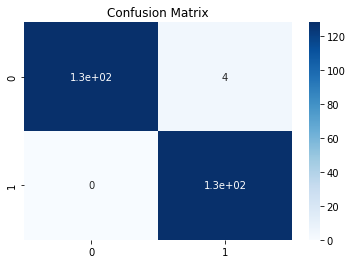

In [29]:
Confusion_mat=confusion_matrix(y_test,dtc_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")

### Extra Trees Classifier

In [30]:
etc = ExtraTreesClassifier(random_state=1)
etc.fit(x_train, y_train)
etc_pred = etc.predict(x_test)
etc_accuracy = accuracy_score(y_test, etc_pred)
etc_matrix = confusion_matrix(y_test, dtc_pred)
etc_f1 = f1_score(etc_pred, y_test, average = 'macro')

In [31]:
print('Accuracy on Extra Tree Classifier is: {}'.format(etc_accuracy))
print('F1_score on Extra Tree Classifier is: {}'.format(etc_f1))
print("The classification report ")
print(classification_report(y_test,etc_pred))

Accuracy on Extra Tree Classifier is: 0.9961538461538462
F1_score on Extra Tree Classifier is: 0.9961533340237605
The classification report 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       132
           1       0.99      1.00      1.00       128

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260



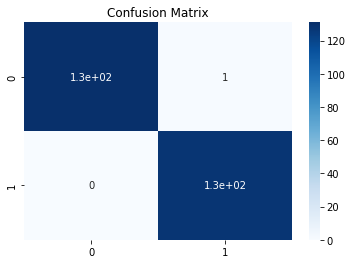

In [32]:
Confusion_mat=confusion_matrix(y_test,etc_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")

### CatBoost Classifier

In [33]:
cat = CatBoostClassifier()
cat.fit(x_train, y_train)
cat_pred = cat.predict(x_test)
cat_accuracy = accuracy_score(y_test, cat_pred)
cat_matrix = confusion_matrix(y_test, cat_pred)
cat_f1 = f1_score(cat_pred, y_test, average = 'macro')

Learning rate set to 0.010459
0:	learn: 0.6764123	total: 49.2ms	remaining: 49.2s
1:	learn: 0.6570757	total: 51.9ms	remaining: 25.9s
2:	learn: 0.6408769	total: 54.5ms	remaining: 18.1s
3:	learn: 0.6237541	total: 56.9ms	remaining: 14.2s
4:	learn: 0.6096333	total: 59.6ms	remaining: 11.9s
5:	learn: 0.5937802	total: 62ms	remaining: 10.3s
6:	learn: 0.5778198	total: 64.5ms	remaining: 9.15s
7:	learn: 0.5641434	total: 67ms	remaining: 8.3s
8:	learn: 0.5499560	total: 69.4ms	remaining: 7.64s
9:	learn: 0.5373698	total: 71.9ms	remaining: 7.12s
10:	learn: 0.5235349	total: 74.3ms	remaining: 6.68s
11:	learn: 0.5126853	total: 76.7ms	remaining: 6.32s
12:	learn: 0.5002638	total: 79.2ms	remaining: 6.01s
13:	learn: 0.4888493	total: 81.7ms	remaining: 5.75s
14:	learn: 0.4799042	total: 84.2ms	remaining: 5.53s
15:	learn: 0.4705120	total: 86.6ms	remaining: 5.33s
16:	learn: 0.4602507	total: 89.1ms	remaining: 5.15s
17:	learn: 0.4522826	total: 91.5ms	remaining: 4.99s
18:	learn: 0.4428445	total: 93.8ms	remaining: 4.8

In [34]:
print('Accuracy on CatBoost Classifier is: {}'.format(cat_accuracy))
print('F1_score on CatBoost Classifier is: {}'.format(cat_f1))
print("The classification report ")
print(classification_report(y_test,cat_pred))

Accuracy on CatBoost Classifier is: 0.9884615384615385
F1_score on CatBoost Classifier is: 0.9884613677717127
The classification report 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       132
           1       0.98      1.00      0.99       128

    accuracy                           0.99       260
   macro avg       0.99      0.99      0.99       260
weighted avg       0.99      0.99      0.99       260



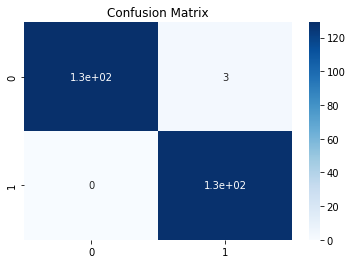

In [35]:
Confusion_mat=confusion_matrix(y_test,cat_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")

### Gradient Boosting Classifier

In [36]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
gbc_pred = gbc.predict(x_test)
gbc_accuracy = accuracy_score(y_test, gbc_pred)
gbc_matrix = confusion_matrix(y_test, gbc_pred)
gbc_f1 = f1_score(gbc_pred, y_test, average = 'macro')

In [37]:
print('Accuracy on Gradient Boosting Classifier is: {}'.format(gbc_accuracy))
print('F1_score on Gradient Boosting Classifier is: {}'.format(gbc_f1))
print("The classification report ")
print(classification_report(y_test,gbc_pred))

Accuracy on Gradient Boosting Classifier is: 0.9884615384615385
F1_score on Gradient Boosting Classifier is: 0.9884613677717127
The classification report 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       132
           1       0.98      1.00      0.99       128

    accuracy                           0.99       260
   macro avg       0.99      0.99      0.99       260
weighted avg       0.99      0.99      0.99       260



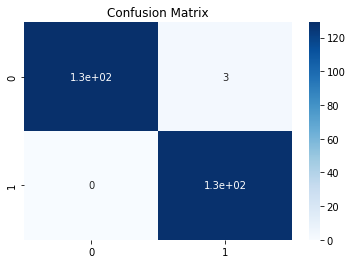

In [38]:
Confusion_mat=confusion_matrix(y_test,gbc_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")

### Random Forest Classifier

In [39]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_test)
rfc_accuracy = accuracy_score(y_test, rfc_pred)
rfc_matrix = confusion_matrix(y_test, rfc_pred)
rfc_f1 = f1_score(rfc_pred, y_test, average = 'macro')

In [40]:
print('Accuracy on Random Forest Classifier is: {}'.format(rfc_accuracy))
print('F1_score on Random Forest Classifier is: {}'.format(rfc_f1))
print("The classification report ")
print(classification_report(y_test,rfc_pred))

Accuracy on Random Forest Classifier is: 0.9923076923076923
F1_score on Random Forest Classifier is: 0.9923072371146222
The classification report 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       132
           1       0.98      1.00      0.99       128

    accuracy                           0.99       260
   macro avg       0.99      0.99      0.99       260
weighted avg       0.99      0.99      0.99       260



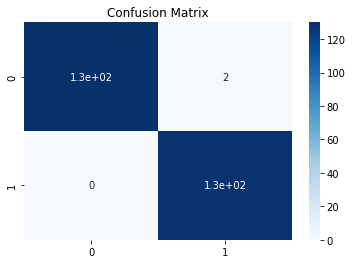

In [41]:
Confusion_mat=confusion_matrix(y_test,rfc_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")

### XGB Classifier

In [42]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_matrix = confusion_matrix(y_test, xgb_pred)
xgb_f1 = f1_score(xgb_pred, y_test, average = 'macro')

In [43]:
print('Accuracy on XGB Classifier is: {}'.format(xgb_accuracy))
print('F1_score on XGB Classifier is: {}'.format(xgb_f1))
print("The classification report ")
print(classification_report(y_test,xgb_pred))

Accuracy on XGB Classifier is: 0.9807692307692307
F1_score on XGB Classifier is: 0.9807689462861877
The classification report 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       132
           1       0.96      1.00      0.98       128

    accuracy                           0.98       260
   macro avg       0.98      0.98      0.98       260
weighted avg       0.98      0.98      0.98       260



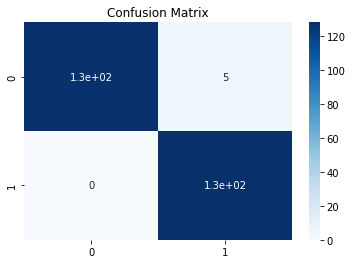

In [44]:
Confusion_mat=confusion_matrix(y_test,xgb_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")

### Ridge Classifier

In [45]:
ridge = RidgeClassifier()
ridge.fit(x_train, y_train)
ridge_pred = ridge.predict(x_test)
ridge_accuracy = accuracy_score(y_test, ridge_pred)
ridge_matrix = confusion_matrix(y_test, ridge_pred)
ridge_f1 = f1_score(ridge_pred, y_test, average = 'macro')

In [46]:
print('Accuracy on ridge Classifier is: {}'.format(ridge_accuracy))
print('F1_score on ridge Classifier is: {}'.format(ridge_f1))
print("The classification report ")
print(classification_report(y_test,ridge_pred))

Accuracy on ridge Classifier is: 0.9076923076923077
F1_score on ridge Classifier is: 0.9076704545454546
The classification report 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       132
           1       0.88      0.94      0.91       128

    accuracy                           0.91       260
   macro avg       0.91      0.91      0.91       260
weighted avg       0.91      0.91      0.91       260



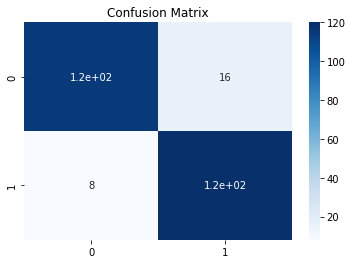

In [47]:
Confusion_mat=confusion_matrix(y_test,ridge_pred)
fig,ax=plt.subplots(figsize=(6,4))
plt.title("Confusion Matrix")
sns.heatmap(Confusion_mat, annot=True, cmap="Blues")